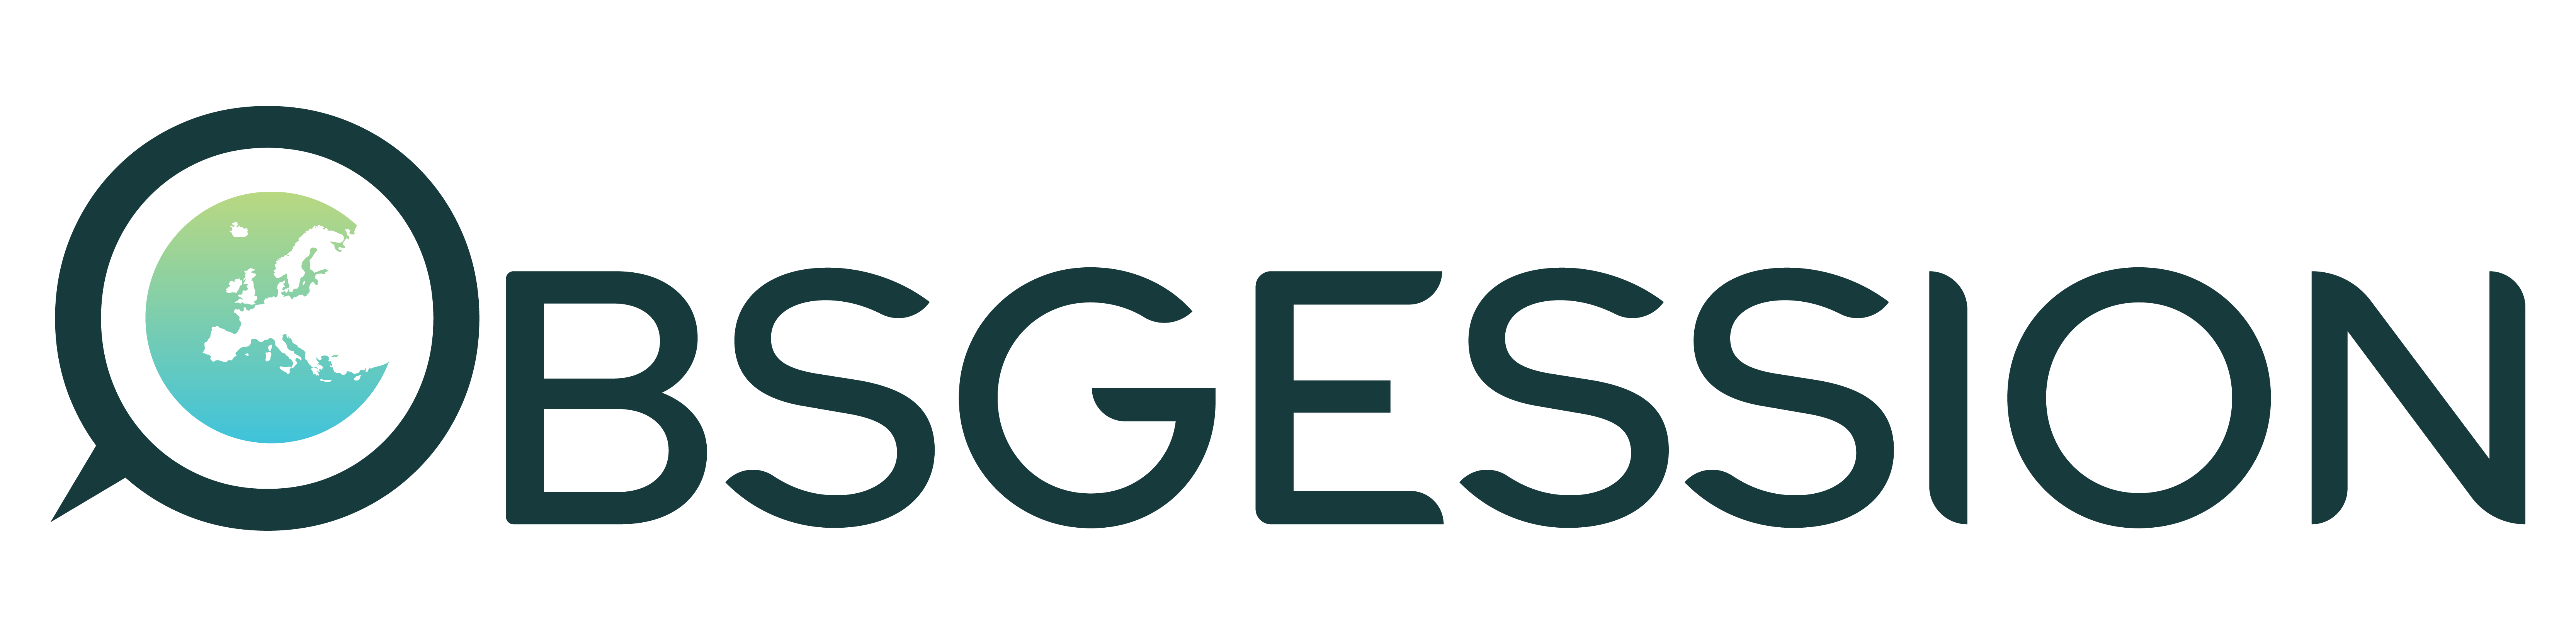

# OBSGESSION internal workshop on EBV-enabling data & data infrastructure
### data processing with openEO - short introduction to use the VITO eo_processing package and the openEO processing platform to generate Sentinel time series and products data cubes
presented by: Dr. Marcel Buchhorn (VITO)
<br>

To run this Jupyter notebook you need the following:
- an CDSE account for data processing in [openEO](https://dataspace.copernicus.eu/). Via green button in the right top corner; following the [documentation to register](https://documentation.dataspace.copernicus.eu/Registration.html).
- an Anaconda Python environment with all needed packages installed
    - follow this manual to set up the Python environment: [python_dev_environment](https://github.com/ESA-WEED-project/.github/tree/main/python_dev_environment)
    - install the eo_processing package in your conda environment:
        - run `conda activate <your_env_name>`
        - run `pip install git+https://github.com/ESA-WEED-project/eo_processing.git@main#egg=eo_processing`

## BASIC example - Sentinel-1 sigma-naught monthly composites 2024
Copyrights, license and restrictions
All code snippets, visualizations or/and workflow ideas are property of VITO. Showed public and private repositories are owned by VITO.
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn. Code usage is allowed with proper citation, see author list in repository.
base repository: https://github.com/ESA-WEED-project/eo_processing

#### import the needed Python packages

In [1]:
import os
import xarray

from eo_processing.utils.helper import init_connection
from eo_processing.openeo.preprocessing import extract_S1_datacube
from eo_processing.config import get_job_options, get_collection_options, get_advanced_options
from eo_processing.utils.geoprocessing import bbox_area, geoJson_2_BBOX
from eo_processing.utils.jobmanager import get_AOI_interactive

#### connect to the openEO processing backend

In [3]:
backend = 'cdse'
# establish the connection to the selected backend
connection = init_connection(backend)

Authenticated using refresh token.


In [9]:
# specify your personal output folder - to make this training notebook work, please select the same folder where your browser saves its downloads
out_root = r'C:\Users\BUCHHORM\Downloads'   # <----- PLEASE ADAPT

#### specify the AOI
We are using here an interactive map in which you can draw a polygon and export it. Please note: for test reasons we limit the AOIs to 100km2.

In [7]:
# we specify the AOI interactive (you can also just load a GeoJson, shapely polygon or set a openEO BBOX manually)
get_AOI_interactive(map_center=(52.2, 6.9), zoom=11)

Please draw the AOI and press the EXPORT button.


In [11]:
# we convert the drawn or loaded Polygon(s) into a openEO BoundingBox object
AOI_bbox = geoJson_2_BBOX(os.path.join(out_root, 'polygon.geojson'), delete_file=True, size_check=100)
print(f"The bounding box is: {AOI_bbox} with an area of {bbox_area(AOI_bbox, only_number=True)} km2")

The bounding box is: {'west': 6.931537, 'south': 52.130959, 'east': 7.020082, 'north': 52.173511, 'crs': 'EPSG:4326'} with an area of 28.694822705523215 km2


## create the openEO processing pipeline by using the `eo_processing` package
All we have to do is to specify the `processing` and `collection` options for the `eo_processing` package and the `job` options for the openEO backend. Moreover, we have to set the time domain. And finally, use the correct datacube generation function (pipeline) to run in openEO.|

In [13]:
# define the options - see here for more details on processing options: https://github.com/ESA-WEED-project/eo_processing/blob/main/README.md
processing_options = get_advanced_options(provider=backend,
                                          target_crs=3035,
                                          resolution=10.,
                                          ts_interpolation=False,
                                          ts_interval='month')
# collection options are the names of the STAC catalogs in the different backends
collection_options = get_collection_options(provider=backend)
# job options specify the openEO cluster settings (number of cores, memory, etc.)
job_options = get_job_options(provider=backend, task='raw_extraction')
# the time context is given by start and end date
start = '2024-01-01'
end = '2025-01-01'   # the end is always exclusive

In [15]:
# define the openEO pipeline to use from the `eo_processing` package pool
data_cube = extract_S1_datacube(connection,
                                AOI_bbox,
                                start,
                                end,
                                **collection_options,
                                **processing_options)

In [17]:
# create openEO job and run
job = data_cube.execute_batch(title=f'S1 datacube for AOI',
                              out_format='NetCDF',
                              job_options=job_options)
# Get the results and save to output file
results = job.get_results()
outputfile = os.path.join(out_root, f'S1_timeseries_2024.nc')
results.download_file(outputfile)

0:00:00 Job 'j-2503301930394335912ac972102e82bd': send 'start'
0:00:13 Job 'j-2503301930394335912ac972102e82bd': created (progress 0%)
0:00:18 Job 'j-2503301930394335912ac972102e82bd': created (progress 0%)
0:00:25 Job 'j-2503301930394335912ac972102e82bd': created (progress 0%)
0:00:33 Job 'j-2503301930394335912ac972102e82bd': queued (progress 0%)
0:00:43 Job 'j-2503301930394335912ac972102e82bd': queued (progress 0%)
0:00:55 Job 'j-2503301930394335912ac972102e82bd': queued (progress 0%)
0:01:10 Job 'j-2503301930394335912ac972102e82bd': queued (progress 0%)
0:01:30 Job 'j-2503301930394335912ac972102e82bd': queued (progress 0%)
0:01:54 Job 'j-2503301930394335912ac972102e82bd': running (progress N/A)
0:02:23 Job 'j-2503301930394335912ac972102e82bd': running (progress N/A)
0:03:01 Job 'j-2503301930394335912ac972102e82bd': running (progress N/A)
0:03:48 Job 'j-2503301930394335912ac972102e82bd': running (progress N/A)
0:04:46 Job 'j-2503301930394335912ac972102e82bd': running (progress N/A)
0

WindowsPath('C:/Users/BUCHHORM/Downloads/S1_timeseries_2024.nc')

##### visualization of results

In [19]:
ts1 = xarray.load_dataset(outputfile)
ts1

<xarray.Dataset> Size: 30MB
Dimensions:  (t: 12, x: 626, y: 499)
Coordinates:
  * t        (t) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
  * x        (x) float64 5kB 4.111e+06 4.111e+06 ... 4.117e+06 4.117e+06
  * y        (y) float64 4kB 3.234e+06 3.234e+06 ... 3.229e+06 3.229e+06
Data variables:
    crs      |S1 1B b''
    VH       (t, y, x) float32 15MB 2.707e+03 2.494e+03 ... 1.987e+03 1.842e+03
    VV       (t, y, x) float32 15MB 5.967e+03 5.313e+03 ... 5.058e+03 5.791e+03
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.65.0a4.dev20...
    description:  
    title:

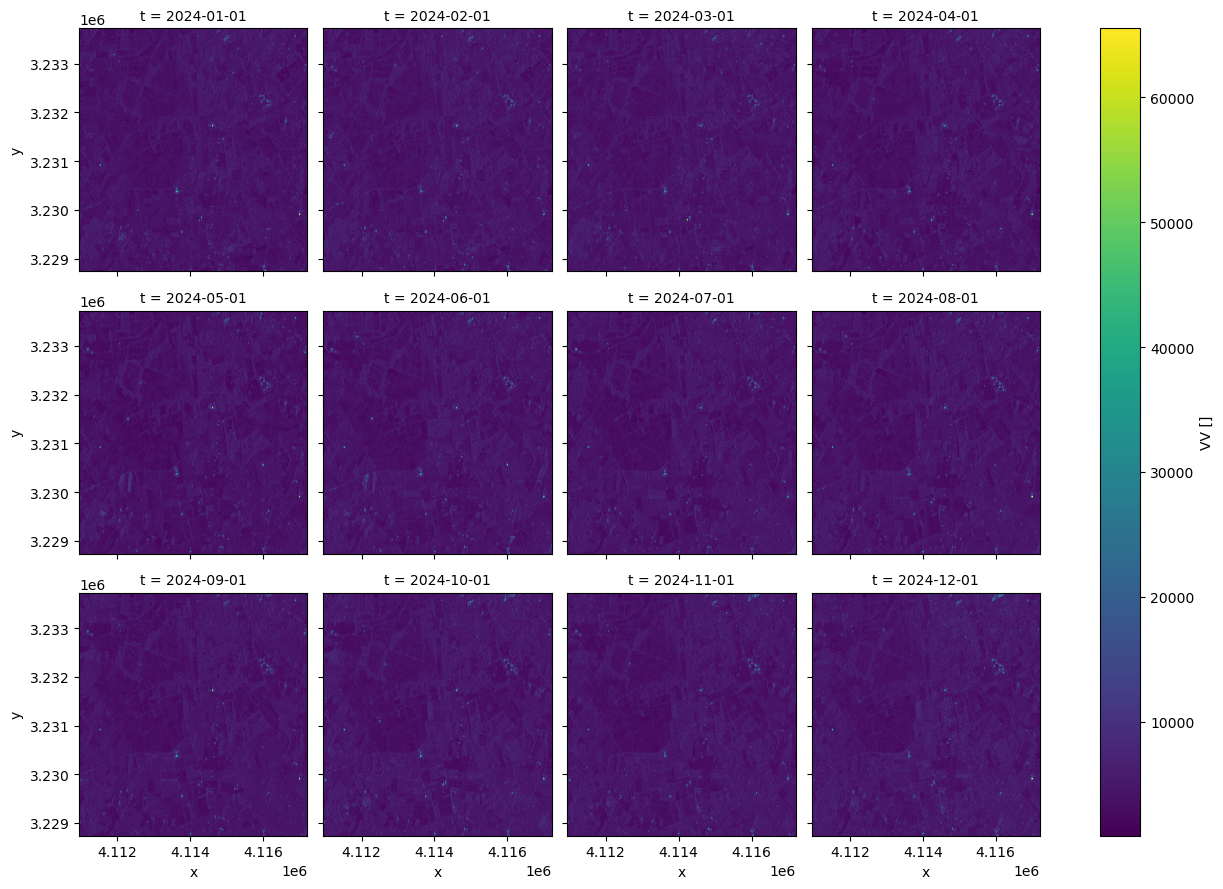

In [21]:
# Visualize the monthly timestamps for VV polarization as FacetGrid
ts1.VV.plot(x="x", y="y", col="t", col_wrap=4)

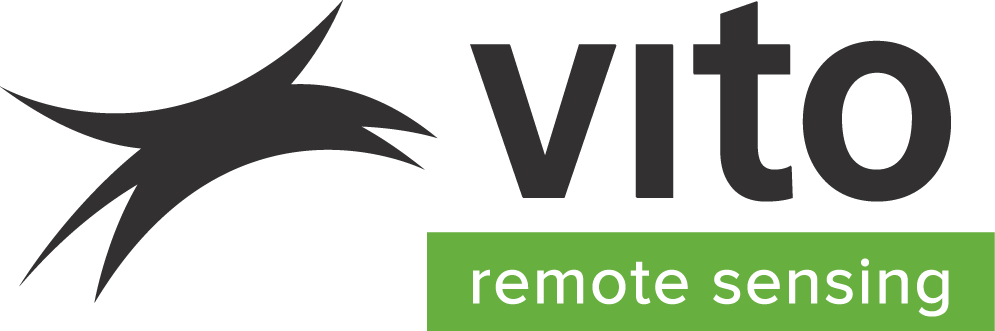